# Разработка нейросетевого подхода для восстановления характеристик частиц

Руководитель:

Алексей Болдырев

https://t.me/aboldyrev

aboldyrev@hse.ru


# Подготовка данных

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import os
from datetime import datetime

from scipy.ndimage.measurements import center_of_mass
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
N_SIGNALS = 10000
N_JOBS = 2

INPUT_PATH = 'https://gitlab.com/lambda-hse/lhcb-ecal-opt-public/-/raw/main/data/converted_downscope_all.csv'
OUTPUT_PATH = './'


# cell_sizes_cm = [1.515, 3.03, 4.04, 6.06, 12.12]
cell_sizes_cm = [1.515]
layers = [0]

SPATIAL_REG = True
ENERGY_REG = True
TIME_REG = True

RANDOM_STATE = 42

if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)
if not os.path.exists(os.path.join(OUTPUT_PATH, 'reg_res_images')):
    os.mkdir(os.path.join(OUTPUT_PATH, 'reg_res_images'))
if not os.path.exists(os.path.join(OUTPUT_PATH, 'reg_res')):
    os.mkdir(os.path.join(OUTPUT_PATH, 'reg_res'))

In [3]:
def get_center_cluster(row):
    return (np.array(center_of_mass(row[1:].reshape(5,5))) - 2.0) * row[0]


def get_rmse(x, y):
    return np.nanmean(((x - y) ** 2.0)) ** 0.5


def get_rmse_metric(x, y, folds=5):
    if x.shape != y.shape:
        print('x.shape != y.shape')
        raise

    splits = np.array_split(np.arange(len(x)), folds)

    rmse = []
    for split in splits:
        rmse.append(get_rmse(x[split], y[split]))

    return np.nanmean(rmse), np.nanstd(rmse)

In [4]:
def get_xgb_model(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, random_state=RANDOM_STATE, shuffle=True)
    kf.get_n_splits(X)

    predict_train = np.zeros(len(X))

    for train_index, val_index in kf.split(X):

        model = xgb.XGBRegressor(n_jobs=N_JOBS,
                                 n_estimators=500,
                                 random_state=RANDOM_STATE,
                                 verbosity = 0)

        model.fit(X[train_index], y[train_index])

        predict_train[val_index] = model.predict(X[val_index])

    return predict_train

In [5]:
def print_spatial_xgb_model_metrics(df, axis):
    print('Before correction:')
    mean_RMSE, std_RMSE = get_rmse_metric(df['l0_{}Gen_loc'.format(axis)].values,
                                          df['l0_{}Rec_loc'.format(axis)].values)
    print('mean_RMSE: {:.5f}, std_RMSE: {:.5f}'.format(mean_RMSE, std_RMSE))

    print('After correction:')
    mean_RMSE, std_RMSE = get_rmse_metric(df['l0_{}Gen_loc'.format(axis)].values,
                                          df['{}Gen_pred'.format(axis)].values)
    print('mean_RMSE: {:.5f}, std_RMSE: {:.5f}'.format(mean_RMSE, std_RMSE))

def fit_pred_spatial_xgb_model(data_train, cell_size_cm):
    train_features = []

    for layer in layers:
        train_features += \
            ['l{}_xRec_loc'.format(layer), 'l{}_yRec_loc'.format(layer)] + \
            ['l{}_sum_5x5_rec'.format(layer)] + \
            ['l{}_sum_3x3'.format(layer)] + \
            ['l{}_sum_5x5'.format(layer)] + \
            ['l{}_{}'.format(layer, i) for i in range(25)]

    for n, axis in enumerate(['x', 'y']):

        predict = get_xgb_model(
                            X=data_train[train_features].values,
                            y=data_train['l0_{}Gen_loc'.format(axis)].values.reshape(-1,1)
                            )

        predict = np.clip(predict, a_min=-2.5*cell_size_cm, 
                                   a_max=2.5*cell_size_cm)

        data_train['{}Gen_pred'.format(axis)] = predict

        print('Metrics on {}TRAIN:'.format(axis))
        print_spatial_xgb_model_metrics(data_train, axis)

        print('\n')

    return data_train['xGen_pred'].values, data_train['yGen_pred'].values

In [6]:
def print_energy_xgb_model_metrics(df):
    mean_RMSE, std_RMSE = get_rmse_metric(df['p_ECAL'].values,
                                          df['l0_sum_5x5_rec'].values)
    print('mean_RMSE {}: {:.5f}, std_RMSE: {:.5f}'.format('l0_sum_5x5_rec', mean_RMSE, std_RMSE))

    mean_RMSE, std_RMSE = get_rmse_metric(df['p_ECAL'].values,
                                          df['p_pred'].values)
    print('mean_RMSE p_pred_xgb: {:.5f}, std_RMSE: {:.5f}'.format(mean_RMSE, std_RMSE))


def fit_pred_energy_xgb_model(data_train, cell_size_cm):
    train_features = []

    for layer in layers:
        train_features += \
            ['l{}_sum_5x5_rec'.format(layer)] + \
            ['l{}_sum_3x3'.format(layer)] + \
            ['l{}_sum_5x5'.format(layer)] + \
            ['l{}_{}'.format(layer, i) for i in range(25)]

    predict = \
            get_xgb_model(
                        X=data_train[train_features].values,
                        y=data_train['p_ECAL'].values.reshape(-1,1)
                        )
    
    predict = np.clip(predict, a_min=0, a_max=None)
    
    data_train['p_pred'] = predict

    print('Energy Metrics on TRAIN:')
    print_energy_xgb_model_metrics(data_train)

    print('\n')

    return data_train['p_pred'].values

In [7]:
def print_time_xgb_model_metrics(df, cell_size_cm):
    feature = 't0_12'

    mean_RMSE, std_RMSE = get_rmse_metric(df['t_ECAL'].values,
                                          df[feature].values)
    print('mean_RMSE {}: {:.5f}, std_RMSE: {:.5f}'.format(feature, mean_RMSE, std_RMSE))

    mean_RMSE, std_RMSE = get_rmse_metric(df['t_ECAL'].values,
                                          df['t_pred'].values)
    print('mean_RMSE t_pred_xgb: {:.5f}, std_RMSE: {:.5f}'.format(mean_RMSE, std_RMSE))


def fit_pred_time_xgb_model(data_train, cell_size_cm):
    train_features = []

    train_features += ['t0_{}'.format(i) for i in range(25)] + \
                      ['t0_weighted_3x3','t0_weighted_5x5']
    
    for layer in layers:
        train_features += \
            ['l{}_sum_5x5_rec'.format(layer)] + \
            ['l{}_sum_3x3'.format(layer)] + \
            ['l{}_sum_5x5'.format(layer)] + \
            ['l{}_{}'.format(layer, i) for i in range(25)]

    data_train['t_pred'] = \
            get_xgb_model(
                        X=data_train[train_features].values,
                        y=data_train['t_ECAL'].values.reshape(-1,1)
                        )

    print('Time Metrics on TRAIN:')
    print_time_xgb_model_metrics(data_train, cell_size_cm)

    print('\n')

    return data_train['t_pred'].values

In [8]:
def get_time_cell_3x3(row):
    time = row[:9]
    energy = row[9:]
    return (time * energy).sum() / (energy.sum() + 1e-6)


def get_time_cell_5x5(row):
    time = row[:25]
    energy = row[25:]
    return (time * energy).sum() / (energy.sum() + 1e-6)


def get_features(df):
    df['xGen_pred'] = 0.0
    df['yGen_pred'] = 0.0
    df['p_pred'] = 0.0
    df['t_pred'] = 0.0

    for layer in layers:
        df['l{}_sum_3x3'.format(layer)] = \
            df[['l{}_{}'.format(layer, i) for i in [6,7,8,
                                                    11,12,13,
                                                    16,17,18]]].values.sum(axis=1)

        df['l{}_sum_5x5'.format(layer)] = \
            df[['l{}_{}'.format(layer, i) for i in range(25)]].values.sum(axis=1)


    df['z_ref'] = np.zeros_like(df['entry_x'].values)
    df.loc[df['cell_size'] == 1.515, 'z_ref'] = 7.0
    df.loc[df['cell_size'] == 3.03, 'z_ref'] = 10.0
    df.loc[df['cell_size'] == 4.04, 'z_ref'] = 17.0
    df.loc[df['cell_size'] == 6.06, 'z_ref'] = 17.0
    df.loc[df['cell_size'] == 12.12, 'z_ref'] = 0.0
    
    barycenter = np.apply_along_axis(get_center_cluster, axis=1,
                                     arr = df[['cell_size'] + \
                                              ['l{}_{}'.format(0, i) for i in range(25)]].values)       
        
    for i, axis in enumerate(['x','y']):
        df['l0_{}_bar'.format(axis)] = \
            barycenter[:,i] + \
            df['{}_seed_shift'.format(axis)].values * df['cell_size'].values

        df['entry_{}_new'.format(axis)] = \
            (df['entry_{}'.format(axis)].values*0.1 + \
             df['z_ref'].values * (df['p{}'.format(axis)].values / df['pz'].values)) * 10

        df['l0_{}_bar_cal'.format(axis)] = \
            np.floor(df['entry_{}'.format(axis)].values * 0.1 / df['cell_size'].values) * \
            df['cell_size'].values + 0.5 * df['cell_size'].values + \
            df['l0_{}_bar'.format(axis)]

        df['l0_{}Rec_loc'.format(axis)] = \
            df['l0_{}_bar_cal'.format(axis)].values - \
            (np.floor(df['l0_{}_bar_cal'.format(axis)].values / df['cell_size'].values) * \
             df['cell_size'].values + 0.5 * df['cell_size'].values)

        df['l0_{}Gen_loc'.format(axis)] = \
            df['entry_{}_new'.format(axis)].values*0.1 - \
            (np.floor(df['l0_{}_bar_cal'.format(axis)].values / df['cell_size'].values) * \
             df['cell_size'].values + 0.5 * df['cell_size'].values)
    
    for layer in layers:
        df['t{}_weighted_3x3'.format(layer)] = np.apply_along_axis(get_time_cell_3x3, 
                                                    axis=1, 
                                                    arr=df[['t{}_{}'.format(layer,c) for c in [6,7,8,11,12,13,16,17,18]] + \
                                                           ['l{}_{}'.format(layer,c) for c in [6,7,8,11,12,13,16,17,18]]].values)

        df['t{}_weighted_5x5'.format(layer)] = np.apply_along_axis(get_time_cell_5x5, 
                                                    axis=1, 
                                                    arr=df[['t{}_{}'.format(layer,c) for c in range(25)] + \
                                                           ['l{}_{}'.format(layer,c) for c in range(25)]].values)

## Калибровка энергии

In [9]:
def calib(df):
    cell_sizes = [1.515, 3.03, 4.04, 6.06, 12.12]

    A = dict()
    B = dict()

    A[0] = dict()
    B[0] = dict()
    A[0][1.515] = 0.00497
    B[0][1.515] = 109.5
    A[0][3.03] = 0.09641
    B[0][3.03] = 23.4
    A[0][4.04] = 0.2382
    B[0][4.04] = 70.72
    A[0][6.06] = 0.2401
    B[0][6.06] = 75.22
    A[0][12.12] = 0.2458
    B[0][12.12] = 57.76

    for layer in layers:
        for cell_size in cell_sizes:
            for cell_num in range(25):
                e_calib = df.loc[df.cell_size == cell_size, 'l{}_{}'.format(layer, cell_num)] * A[layer][cell_size] + \
                        B[layer][cell_size]
                df.loc[df.cell_size == cell_size, 'l{}_{}'.format(layer, cell_num)] = \
                    np.clip(e_calib, a_min=0, a_max=None)

    return df

# Baseline-решение

In [10]:
nPV_start_time = datetime.now()
data_train = pd.read_csv(INPUT_PATH)[:N_SIGNALS]

data_train = data_train[~np.isnan(data_train.l0_12.values)].reset_index(drop=True)

data_train = calib(data_train)

data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
data_train.fillna(0, inplace=True)

data_train['p_ECAL'] = data_train['eKinetic'].values * 1000
data_train['t_ECAL'] = data_train.timing.values

data_train['x_ECAL'] = data_train.entry_x.values
data_train['y_ECAL'] = data_train.entry_y.values
data_train['z_ECAL'] = data_train.entry_z.values

for layer in layers:
    data_train['l{}_sum_5x5_rec'.format(layer)] = 0.0

    for cell_size in cell_sizes_cm:
        sum_of_cluster = data_train[data_train.cell_size == cell_size][['l{}_{}'.format(layer, i) for i in range(25)]].values.sum(axis=-1)
        corr_coef = np.nanmean((data_train[data_train.cell_size == cell_size].p_ECAL.values)) / np.nanmean(sum_of_cluster)
        data_train.loc[data_train.cell_size == cell_size, 'l{}_sum_5x5_rec'.format(layer)] = sum_of_cluster * corr_coef

get_features(data_train)

data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
data_train.fillna(0, inplace=True)

for cell_size in cell_sizes_cm:
    print('###################################################################################')

    cell_start_time = datetime.now()

    print('cell_size: ', cell_size)

    if SPATIAL_REG:
        print('Spatial reconstruction regressor...')
        regressor_start_time = datetime.now()
        data_train.loc[data_train.cell_size == cell_size, 'xGen_pred'], \
        data_train.loc[data_train.cell_size == cell_size, 'yGen_pred'] = \
            fit_pred_spatial_xgb_model(data_train[data_train.cell_size == cell_size], cell_size_cm=cell_size)

        print('time: {}'.format(datetime.now() - regressor_start_time))

    if ENERGY_REG:
        print('Energy reconstruction regressor...')
        regressor_start_time = datetime.now()
        data_train.loc[data_train.cell_size == cell_size, 'p_pred'] = \
            fit_pred_energy_xgb_model(data_train[data_train.cell_size == cell_size], cell_size_cm=cell_size)

        print('time: {}'.format(datetime.now() - regressor_start_time))

    if TIME_REG:
        print('Time reconstruction regressor...')
        regressor_start_time = datetime.now()
        data_train.loc[data_train.cell_size == cell_size, 't_pred'] = \
            fit_pred_time_xgb_model(data_train[data_train.cell_size == cell_size], cell_size_cm=cell_size)

        print('time: {}'.format(datetime.now() - regressor_start_time))

    print('cell_size: {} process duration: {}'.format(cell_size, datetime.now() - cell_start_time))


data_train.to_csv(os.path.join(OUTPUT_PATH, \
                    'reg_res/train_result_nPV_0.csv'), index=False)

print('nPV: process duration: {}'.format(datetime.now() - nPV_start_time))
print('\n')

###################################################################################
cell_size:  1.515
Spatial reconstruction regressor...
Metrics on xTRAIN:
Before correction:
mean_RMSE: 0.20855, std_RMSE: 0.00485
After correction:
mean_RMSE: 0.06848, std_RMSE: 0.00415


Metrics on yTRAIN:
Before correction:
mean_RMSE: 0.21395, std_RMSE: 0.00457
After correction:
mean_RMSE: 0.05111, std_RMSE: 0.00166


time: 0:00:25.316352
Energy reconstruction regressor...
Energy Metrics on TRAIN:
mean_RMSE l0_sum_5x5_rec: 10056.97258, std_RMSE: 950.91294
mean_RMSE p_pred_xgb: 12720.08050, std_RMSE: 2905.60043


time: 0:00:04.474794
Time reconstruction regressor...
Time Metrics on TRAIN:
mean_RMSE t0_12: 43.53070, std_RMSE: 0.00098
mean_RMSE t_pred_xgb: 0.02712, std_RMSE: 0.00261


time: 0:00:07.948662
cell_size: 1.515 process duration: 0:00:37.742760
nPV: process duration: 0:00:42.792270




# Пространственное разрешение

In [11]:
df = data_train.copy()
import copy
import matplotlib as mpl

def plot_cell(ax, cell_size=1.515, color='k'):
    lim = 0.5 * cell_size
    ax.axhline(y=lim, color=color, ls='dashed')
    ax.axhline(y=-lim, color=color, ls='dashed')
    ax.axvline(x=lim, color=color, ls='dashed')
    ax.axvline(x=-lim, color=color, ls='dashed')

In [12]:
fig, ax  = plt.subplots(1,3, figsize=(20,6))

sel = (df.cell_size == cell_size)

lim = 0.5 * cell_size
lims = 2 * lim
bounds = [[-lims,lims], [-lims,lims]]
my_cmap = copy.copy(mpl.cm.get_cmap('inferno'))
my_cmap.set_bad((0,0,0))

ax[0].hist2d(df[sel]['l0_xRec_loc'], df[sel]['l0_xGen_loc'], \
             bins=[50, 50], \
             range=bounds, \
             cmap=my_cmap, density=True)
ax[0].set_xlabel('l0_xRec_loc, cm')
ax[0].set_ylabel('l0_xGen_loc, cm')

ax[1].hist2d( df[sel]['l0_yRec_loc'], df[sel]['l0_yGen_loc'],\
             bins=[50, 50], \
             range=bounds, \
             cmap=my_cmap, density=True)
ax[1].set_xlabel('l0_xRec_loc, cm')
ax[1].set_ylabel('l0_xGen_loc, cm')


ax[2].hist2d(df[sel]['l0_xRec_loc'], df[sel]['l0_yRec_loc'], \
             bins=[50, 50], \
             range=bounds, \
             cmap=my_cmap, norm=mpl.colors.LogNorm(), density=True)
ax[2].set_xlabel('l0_xRec_loc, cm')
ax[2].set_ylabel('l0_yRec_loc, cm')

plot_cell(cell_size=cell_size, color='w', ax=ax[0])
plot_cell(cell_size=cell_size, color='w', ax=ax[1])
plot_cell(cell_size=cell_size, color='w', ax=ax[2])

plt.show()

meanRMSE, stdRMSE = get_rmse_metric(df[sel]['l0_xGen_loc'].values, df[sel]['l0_xRec_loc'].values)
print('mean_xRMSE: {:.5f}'.format(meanRMSE), 'std_xRMSE: {:.5f}'.format(stdRMSE))

meanRMSE, stdRMSE = get_rmse_metric(df[sel]['l0_yGen_loc'].values, df[sel]['l0_yRec_loc'].values)
print('mean_yRMSE: {:.5f}'.format(meanRMSE), 'std_yRMSE: {:.5f}'.format(stdRMSE))

mean_xRMSE: 0.20855 std_xRMSE: 0.00485
mean_yRMSE: 0.21395 std_yRMSE: 0.00457


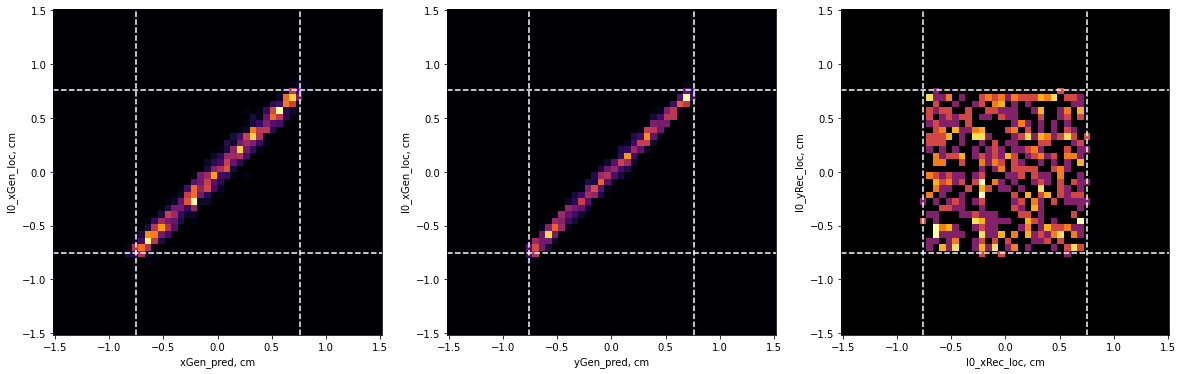

Baseline estimates:
mean_xRMSE: 0.06848 std_xRMSE: 0.00415
mean_yRMSE: 0.05111 std_yRMSE: 0.00166


In [13]:
fig, ax  = plt.subplots(1,3, figsize=(20,6))

sel = (df.cell_size == cell_size)

lim = 0.5 * cell_size
lims = 2 * lim
bounds = [[-lims,lims], [-lims,lims]]
my_cmap = copy.copy(mpl.cm.get_cmap('inferno')) 
my_cmap.set_bad((0,0,0))

ax[0].hist2d(df[sel]['xGen_pred'], df[sel]['l0_xGen_loc'], \
             bins=[50, 50], \
             range=bounds, \
             cmap=my_cmap, density=True)
ax[0].set_xlabel('xGen_pred, cm')
ax[0].set_ylabel('l0_xGen_loc, cm')

ax[1].hist2d(df[sel]['yGen_pred'], df[sel]['l0_yGen_loc'],\
             bins=[50, 50], \
             range=bounds, \
             cmap=my_cmap, density=True)
ax[1].set_xlabel('yGen_pred, cm')
ax[1].set_ylabel('l0_xGen_loc, cm')


ax[2].hist2d(df[sel]['xGen_pred'], df[sel]['yGen_pred'], \
             bins=[50, 50], \
             range=bounds, \
             cmap=my_cmap, norm=mpl.colors.LogNorm(), density=True)
ax[2].set_xlabel('l0_xRec_loc, cm')
ax[2].set_ylabel('l0_yRec_loc, cm')

plot_cell(cell_size=cell_size, color='w', ax=ax[0])
plot_cell(cell_size=cell_size, color='w', ax=ax[1])
plot_cell(cell_size=cell_size, color='w', ax=ax[2])

plt.show()

print('Baseline estimates:')
meanRMSE, stdRMSE = get_rmse_metric(df[sel]['l0_xGen_loc'].values, df[sel]['xGen_pred'].values)
print('mean_xRMSE: {:.5f}'.format(meanRMSE), 'std_xRMSE: {:.5f}'.format(stdRMSE))

meanRMSE, stdRMSE = get_rmse_metric(df[sel]['l0_yGen_loc'].values, df[sel]['yGen_pred'].values)
print('mean_yRMSE: {:.5f}'.format(meanRMSE), 'std_yRMSE: {:.5f}'.format(stdRMSE))

# Энергетическое разрешение

In [14]:
!pip install lmfit
from lmfit.models import GaussianModel
from lmfit import Model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
def extract_energy_resolution(df):
    cell_size = 1.515
    mod = GaussianModel()
    E_bins = [10000., 30000., 50000., 70000., 90000.]

    sel = (df.cell_size == cell_size) & (df.p_pred >= np.min(df.p_ECAL)) & (df.p_pred <= np.max(df.p_ECAL)) #\
    df = df[sel & (df.p_ECAL > E_bins[0]) & (df.p_ECAL < E_bins[-1])].reset_index(drop=True)
    target = df.p_pred
    n_stds = 5

    range_all = (-n_stds*np.std(target - df.p_ECAL), n_stds*np.std(target - df.p_ECAL))

    fig, ax = plt.subplots(1, len(E_bins)-1, figsize=(20,3))
    bins_plotting = (np.array(E_bins[:-1]) + np.array(E_bins[1:])) / 2.0
    sigmas = []
    sigmas_std = []

    for i in range(len(E_bins)-1):
        mask = (df.p_ECAL >= E_bins[i]) & (df.p_ECAL < E_bins[i+1])
        bin_heights, bin_borders, _ = ax[i].hist(target[mask]/df.p_ECAL[mask] - 1, bins=30, \
             range=(-n_stds*np.std(target[mask]/df.p_ECAL[mask] - 1), n_stds*np.std(target[mask]/df.p_ECAL[mask] - 1)))
        bin_centers = (bin_borders[:-1] + bin_borders[1:]) / 2.0
        pars = mod.guess(bin_heights, x = bin_centers)
        out = mod.fit(bin_heights, pars, x = bin_centers)
        x = np.linspace(bin_borders[0], bin_borders[-1], 200)
        ax[i].plot(bin_centers, out.best_fit, label='best fit')
        ax[i].set_title(f'Bin {i} ({0.001*E_bins[i]}-{0.001*E_bins[i+1]} GeV, {len(df.p_ECAL[mask])} entries)')
        ax[i].set_xlabel(r'$E_{rec} - E_{gen}$ [GeV]', fontsize=14)

        sigmas.append(out.params['sigma'].value)
        sigmas_std.append(out.params['sigma'].stderr)
        
    return sigmas, sigmas_std

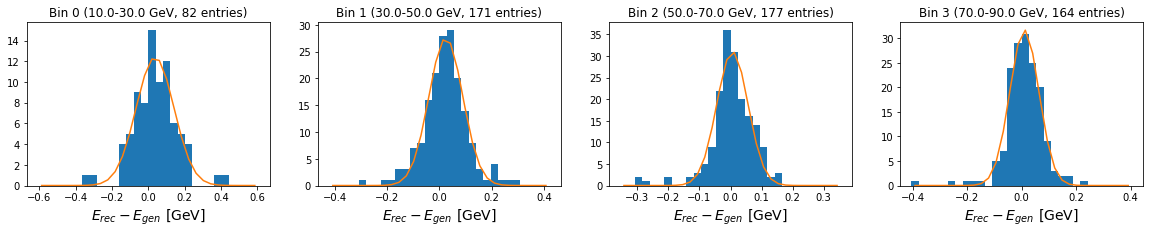

In [16]:
sigmas, sigmas_std = extract_energy_resolution(df)

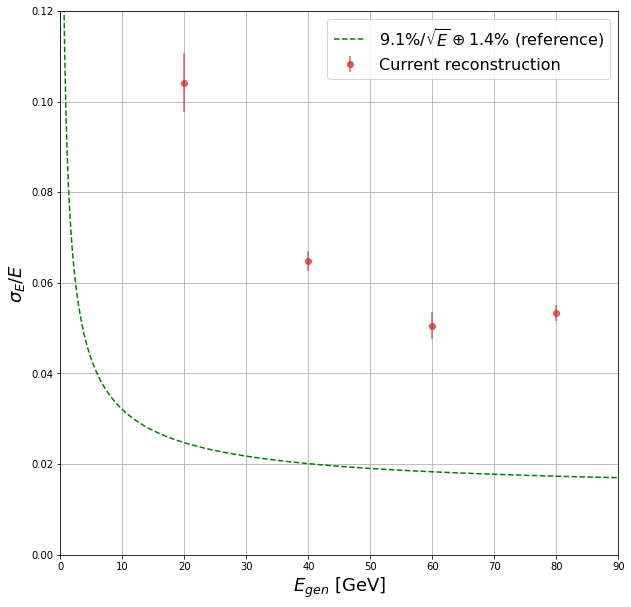

In [17]:
fig, ax = plt.subplots(figsize=(10,10))

def res_fit(x, a, b, c):
    return (a*a/x + b*b)**0.5/100

x_ref = [20, 40, 60, 80]
x_fit = np.linspace(0.1, 100, 1000)
y_fit = res_fit(x_fit, 9.1, 1.4, 0)
    
y_b = sigmas
yerr_b = sigmas_std

ax.set_xlabel(r'$E_{gen}$ [GeV]', fontsize=18)
ax.set_ylabel(r'$\sigma_{E}/E$', fontsize=18)
ax.set_ylim(0., 0.12)
ax.set_xlim(0., 90)
ax.grid(True, which="both")

ax.errorbar(x_ref, y_b, yerr=yerr_b, fmt='o', c='C03', alpha=0.7, label='Current reconstruction')
ax.plot(x_fit, y_fit, 'g--', label=f"9.1%" + r"$/\sqrt{E}\oplus$" + f"1.4% (reference)")
ax.legend(fontsize=16, loc='upper right')

# Временное разрешение

In [18]:
def extract_timing_resolution(df):
    cell_size = 1.515
    mod = GaussianModel()
    E_bins = [10000., 30000., 50000., 70000., 90000.]

    sel = (df.cell_size == cell_size) & (df.p_pred >= np.min(df.p_ECAL)) & (df.p_pred <= np.max(df.p_ECAL)) #\
    df = df[sel & (df.p_ECAL > E_bins[0]) & (df.p_ECAL < E_bins[-1])].reset_index(drop=True)
    target = df.t_pred
    n_stds = 5

    range_all = (-n_stds*np.std(target - df.t_ECAL), n_stds*np.std(target - df.t_ECAL))

    fig, ax = plt.subplots(1, len(E_bins)-1, figsize=(20,3))
    bins_plotting = (np.array(E_bins[:-1]) + np.array(E_bins[1:])) / 2.0
    sigmas = []
    sigmas_std = []

    for i in range(len(E_bins)-1):
        mask = (df.p_ECAL >= E_bins[i]) & (df.p_ECAL < E_bins[i+1])
        bin_heights, bin_borders, _ = ax[i].hist(target[mask]/df.t_ECAL[mask] - 1, bins=30, \
             range=(-n_stds*np.std(target[mask]/df.t_ECAL[mask] - 1), n_stds*np.std(target[mask]/df.t_ECAL[mask] - 1)), color='C02')
        bin_centers = (bin_borders[:-1] + bin_borders[1:]) / 2.0
        pars = mod.guess(bin_heights, x = bin_centers)
        out = mod.fit(bin_heights, pars, x = bin_centers)
        x = np.linspace(bin_borders[0], bin_borders[-1], 200)
        ax[i].plot(bin_centers, out.best_fit, label='best fit', color='C03')
        ax[i].set_title(f'Bin {i} ({0.001*E_bins[i]}-{0.001*E_bins[i+1]} GeV, {len(df.p_ECAL[mask])} entries)')
        ax[i].set_xlabel(r'$t_{rec} - t_{gen}$ [ns]', fontsize=14)

        sigmas.append(out.params['sigma'].value)
        sigmas_std.append(out.params['sigma'].stderr)
        
    return sigmas, sigmas_std

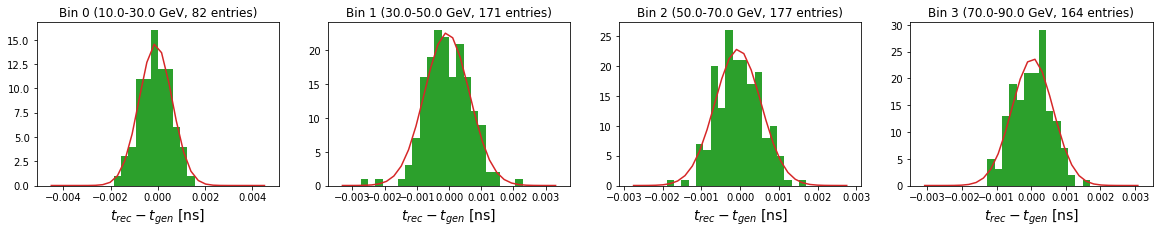

In [19]:
sigmas, sigmas_std = extract_timing_resolution(df)

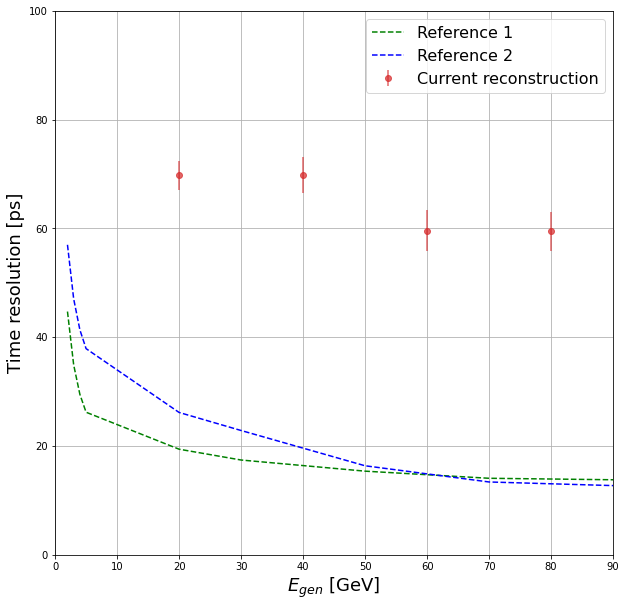

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

x = [20, 40, 60, 80]

x_ref = [2., 3., 4., 5., 20., 30., 50., 70., 100.]
y_ref1 = [44.71,34.90,29.48,26.19,19.39,17.40,15.35,14.04,13.63]
y_ref2 = [56.99,47.04,41.35,37.89,26.15,22.83,16.34,13.36,12.36]

y_b = [i*100000 for i in sigmas]
yerr_b = [i*100000 for i in sigmas_std]

ax.set_xlabel(r'$E_{gen}$ [GeV]', fontsize=18)
ax.set_ylabel('Time resolution [ps]', fontsize=18)
ax.set_ylim(0., 100)
ax.set_xlim(0., 90)
ax.grid(True, which="both")

ax.errorbar(x, y_b, yerr=yerr_b, fmt='o', c='C03', alpha=0.7, label='Current reconstruction')
ax.plot(x_ref, y_ref1, 'g--', label="Reference 1")
ax.plot(x_ref, y_ref2, 'b--', label="Reference 2")
ax.legend(fontsize=16, loc='upper right')